In [26]:
import pylab as pl
import numpy as np
import scipy as sp
from numpy.linalg import eig
from scipy.io import loadmat
import pdb

In [27]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    # extract images and labels
    X = data['X']
    Y = data['Y']
    # collapse the time-electrode dimensions
    X = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = np.sign((Y[0,:]>0) -.5)
    # pick only first 500 (1000, 3000) datapoints and compare optimal shrinkage
    X= X[:,:500]
    Y= Y[:500]
    print(X.shape)
    return X,Y

In [28]:
def crossvalidate_nested(X,Y,f,gammas):
    ''' 
    Optimize shrinkage parameter for generalization performance 
    Input:	X	data (dims-by-samples)
                Y	labels (1-by-samples)
                f	number of cross-validation folds
                gammas	a selection of shrinkage parameters
                trainfunction 	trains linear classifier, returns weight vector and bias term
    '''
    # the next two lines reshape vector of indices in to a matrix:
    # number of rows = # of folds
    # number of columns = # of total data-points / # folds
    N = f*int(np.floor(X.shape[-1]/f))
    idx = np.reshape(np.arange(N),(f,int(np.floor(N/f)))) 
    # pdb.set_trace()
    acc_test = np.zeros((f))
    testgamma = np.zeros((gammas.shape[-1],f))
    
    # loop over folds:
    # select one row of 'idx' for testing, all other rows for training
    # call variables (indices) for training and testing 'train' and 'test'
    for ifold in np.arange(f):
        test_index = idx[ifold, :]
        train_index = np.hstack(idx[np.arange(f) != ifold, :])
        
        X_train, X_test = X[:, train_index], X[:, test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # loop over gammas
        inner_accuracies = np.zeros(len(gammas))
        for igamma in range(gammas.shape[-1]):
            # each gamma is fed into the inner CV via the function 'crossvalidate_lda'
            # the resulting variable is called 'testgamma'
            current_gamma = gammas[igamma]  # Correctly refer to the current gamma value
            inner_accuracies[igamma] = crossvalidate_lda(X_train, Y_train, f - 1, current_gamma)
            # find the the highest accuracy of gammas for a given fold and use it to train an LDA on the training data
        
        best_gamma_idx = np.argmax(inner_accuracies)
        best_gamma = gammas[best_gamma_idx]
        testgamma[:, ifold] = inner_accuracies
        
        w, b = train_lda(X_train, Y_train, best_gamma)
        
        # calculate the accuracy for this LDA classifier on the test data
        predictions = np.sign(X_test.T @ w + b)
        acc_test[ifold] = np.mean(predictions == Y_test)

    # do some plotting
    pl.figure()
    pl.boxplot(testgamma.T)
    pl.xticks(np.arange(gammas.shape[-1])+1,gammas)
    pl.xlabel('$\gamma$')
    pl.ylabel('Accuracy')
    pl.savefig('cv_nested-boxplot.pdf')

    return acc_test,testgamma

In [29]:
def crossvalidate_lda(X,Y,f,gamma):
    ''' 
    Test generalization performance of shrinkage lda
    Input:	X	data (dims-by-samples)
                Y	labels (1-by-samples)
                f	number of cross-validation folds
                trainfunction 	trains linear classifier, returns weight vector and bias term
    '''
    N = f*int(np.floor(X.shape[-1]/f))
    idx = np.reshape(np.arange(N),(f,int(np.floor(N/f))))
    acc_test = np.zeros((f))
    
    # loop over folds
    # select one row of idx for testing, all others for training
    # call variables (indices) for training and testing 'train' and 'test'
    for ifold in np.arange(f):
        test_index = idx[ifold, :]  # select one row for testing
        train_index = np.hstack(idx[np.arange(f) != ifold, :])  # select other rows for training
        
        # selecting indices for training and testing
        X_train, X_test = X[:, train_index], X[:, test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        # train LDA classifier with training data and given gamma:
        w,b = train_lda(X_train,Y_train,gamma)
        # test classifier on test data:
        predictions = np.sign(X_test.T @ w + b)
        acc_test[ifold] = np.mean(predictions == Y_test)
    return acc_test.mean()

In [30]:
def train_lda(X,Y,gamma):
    '''
    Train a nearest centroid classifier
    '''
    # class means
    mupos = np.mean(X[:,Y>0],axis=1)
    muneg = np.mean(X[:,Y<0],axis=1)

    # inter and intra class covariance matrices
    Sinter = np.outer(mupos-muneg,mupos-muneg)
    #Sinter = np.outer(muneg-mupos,muneg-mupos)
    Sintra = np.cov(X[:,Y>0]) + np.cov(X[:,Y<0])
    # shrink covariance matrix estimate
    nu = np.mean(np.diag(Sintra))
    Shrink = (1 - gamma) * Sintra + gamma * nu * np.eye(Sintra.shape[0])
    # solve eigenproblem
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Shrink).dot(Sinter))
    # weight vector
    w = eigvecs[:, np.argmax(eigvals)]
    # offset
    b = (np.dot(w, mupos) + np.dot(w, muneg)) / 2.
    # return the weight vector
    return w,b

(310, 500)


C:\Users\Yerassyl\AppData\Local\Temp\ipykernel_17760\1183828504.py:2: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  gammas=sp.array([0,.005,.05,.5,1])


[0.64 0.44 0.74 0.68 0.54 0.32 0.68 0.72 0.74 0.72]
[[0.55777778 0.49555556 0.50666667 0.50444444 0.51777778 0.52222222
  0.54222222 0.53111111 0.55555556 0.58222222]
 [0.52888889 0.38       0.49333333 0.60444444 0.52       0.47555556
  0.56666667 0.48222222 0.65555556 0.52444444]
 [0.50222222 0.47555556 0.55555556 0.56       0.49333333 0.57555556
  0.52444444 0.48666667 0.46666667 0.58888889]
 [0.42888889 0.40222222 0.41777778 0.55777778 0.50222222 0.52666667
  0.44444444 0.36666667 0.41777778 0.55333333]
 [0.48888889 0.49333333 0.49333333 0.52444444 0.52444444 0.5
  0.49111111 0.48222222 0.5        0.53333333]]


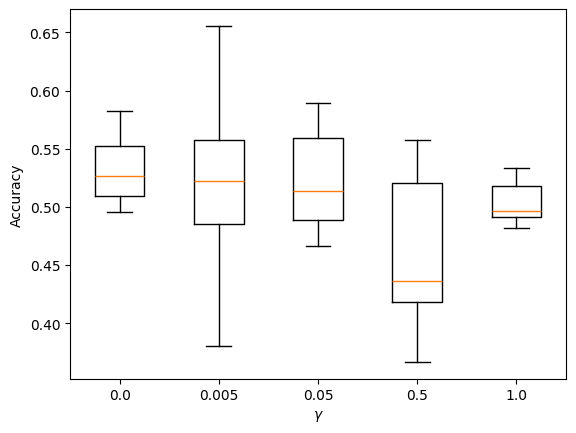

In [31]:
X,Y = load_data('bcidata.mat')
gammas=sp.array([0,.005,.05,.5,1])
a,b = crossvalidate_nested(X,Y,10,gammas)
print(a)
print(b)
